In [1]:
import h5py
import pylab as pl
import numpy as np
#import matplotlib as mpl
import networkx
import scipy.stats as sps
#import ipyvolume as ipv

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2
    
    
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [4]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
def plotTvsZ(fofID, centralID):
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(127*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
#     Idlist, zlist, zcen = [], [], []
    Idlist, templist, zlist = [], [], [] # that's it.

    galH, cenH = [], []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        zt = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        galH.append(pgal)
        cenH.append(pcen)
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             tempT = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            tempT = tempFromMass(Mass, Abund, IE, ne1)
            Idlist.extend(list(tempIds))
            templist.extend(list(tempT))
            zlist.extend([zt]*tempIds.size)

#     Idlist, zlist = np.array(Idlist), np.array(zlist)
    Idlist, templist, zlist = np.array(Idlist), np.array(templist), np.array(zlist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    templist = templist[Idunique]

    galH = np.array(galH)
    cenH = np.array(cenH)
#     zcen = np.array(zcen)
    
    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_127/SubGroups/PartType0/Offsets'][fofID].astype('int')
    TdayCoord = sim['SnapNumber_127/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    LostCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_]

    # ... and the redshift
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
#     zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]
    templist_, Idlist_ = templist[iidex_], Idlist[iidex_]
    zlist_ = zlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    temporder = np.zeros(IndexT_.size)
    temporder[is1] = templist_[is2]
    
    zorder = np.zeros(IndexT_.size)
    zorder[is1] = zlist_[is2]
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_127/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_127/SubGroups/SubGroupPos'][centralID]

    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut]
    zorder_near = zorder[icut]
    temporder_near = temporder[icut]
#     IndexT_near = IndexT_
#     zorder_near = zorder
    
    
    pl.figure(figsize=(18,10))
    
#     pl.plot(zorder_near, temporder_near, ls='', marker='o')
    medT, xz, numbers = sps.binned_statistic(zorder_near, temporder_near, statistic='median', bins=10)
    stdT, xz, numbers = sps.binned_statistic(zorder_near, temporder_near, statistic='std', bins=10)
    countT, xz, numbers = sps.binned_statistic(zorder_near, temporder_near, statistic='std', bins=10)
    
    errT = np.sqrt(np.pi/2)*stdT/np.sqrt(countT)
    
    xz_ = (xz[1:]+xz[:-1])*.5
    pl.errorbar(xz_, medT, yerr=errT, marker='o', ls='')
    
    pl.xlabel('redshift')
#     pl.ylabel('Internal Energy [km^2/s^2]')
    pl.ylabel('Temperature/K')

<ipython-input-5-8117d707b540>:107: RuntimeWarning: invalid value encountered in true_divide
  errT = np.sqrt(np.pi/2)*stdT/np.sqrt(countT)


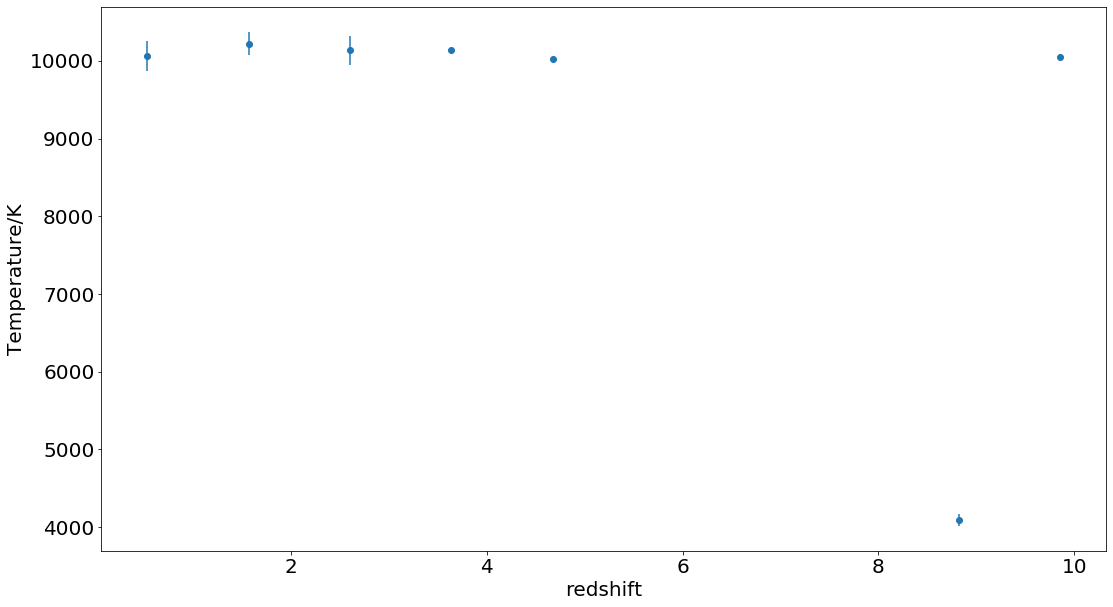

In [6]:
#  4338, 4341 (4337), 4470 y 4474 (4469)
plotTvsZ(4338,4337)

<ipython-input-5-8117d707b540>:107: RuntimeWarning: invalid value encountered in true_divide
  errT = np.sqrt(np.pi/2)*stdT/np.sqrt(countT)


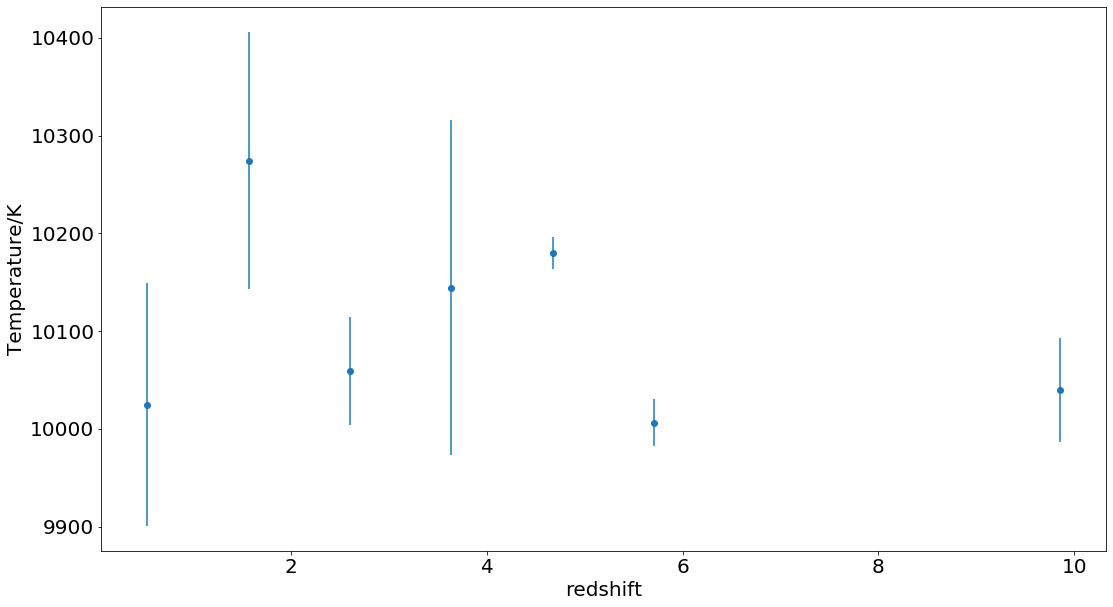

In [7]:
# 33, 35, 82, 85
plotTvsZ(4341,4337)

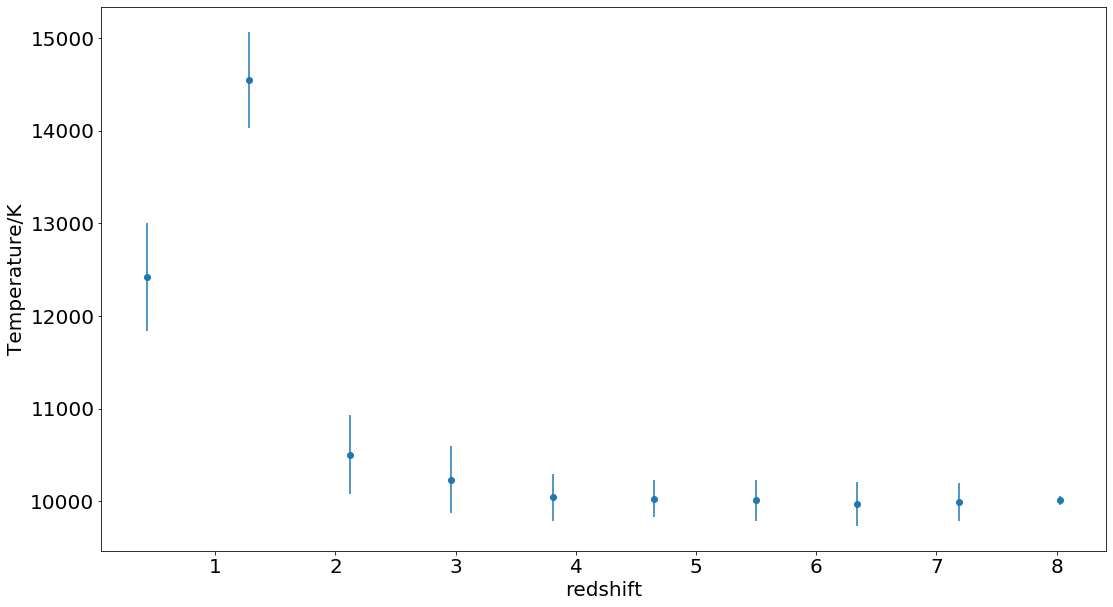

In [8]:
plotTvsZ(4470,4469)

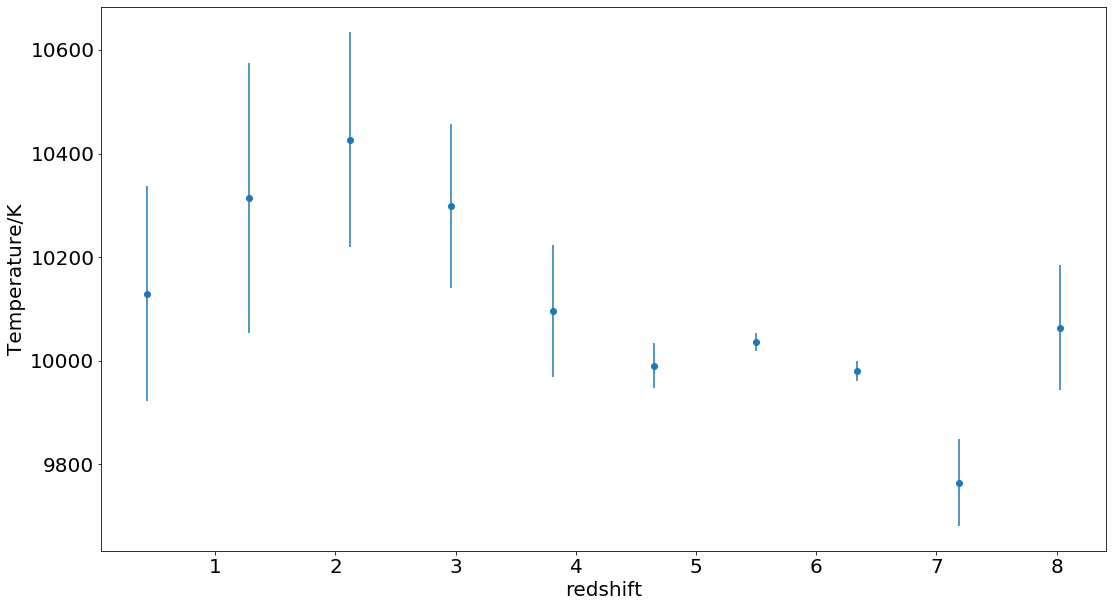

In [9]:
plotTvsZ(4474,4469)